In [57]:
# for presentation purposes
import warnings
warnings.filterwarnings("ignore")


import os

# transform
import numpy as np
import pandas as pd

# visualize 
import matplotlib.pyplot as plt
import seaborn as sns

# working with dates
from datetime import datetime

# modeling
import statsmodels.api as sm
from statsmodels.tsa.api import Holt, ExponentialSmoothing

# evaluate
from sklearn.metrics import mean_squared_error
from math import sqrt 
import itertools

In [3]:
df = pd.read_csv("saas.csv")

In [4]:
df

,Month_Invoiced,Customer_Id,Invoice_Id,Subscription_Type,Amount
0,2014-01-31,1000000,5000000,0.0,0.0
1,2014-01-31,1000001,5000001,2.0,10.0
2,2014-01-31,1000002,5000002,0.0,0.0
3,2014-01-31,1000003,5000003,0.0,0.0
4,2014-01-31,1000004,5000004,1.0,5.0
...,...,...,...,...,...
790453,2017-12-31,1029395,5790453,0.0,0.0
790454,2017-12-31,1029396,5790454,0.0,0.0
790455,2017-12-31,1029397,5790455,3.0,15.0
790456,2017-12-31,1029398,5790456,0.0,0.0


In [6]:
df.Month_Invoiced = pd.to_datetime(df['Month_Invoiced'])

In [8]:
df = df.set_index('Month_Invoiced').sort_index()

In [9]:
df.resample

,Customer_Id,Invoice_Id,Subscription_Type,Amount
Month_Invoiced,,,,
2014-01-31,1000000,5000000,0.0,0.0
2014-01-31,1000001,5000001,2.0,10.0
2014-01-31,1000002,5000002,0.0,0.0
2014-01-31,1000003,5000003,0.0,0.0
2014-01-31,1000004,5000004,1.0,5.0
...,...,...,...,...
2017-12-31,1029395,5790453,0.0,0.0
2017-12-31,1029396,5790454,0.0,0.0
2017-12-31,1029397,5790455,3.0,15.0


<Axes: xlabel='Month_Invoiced'>

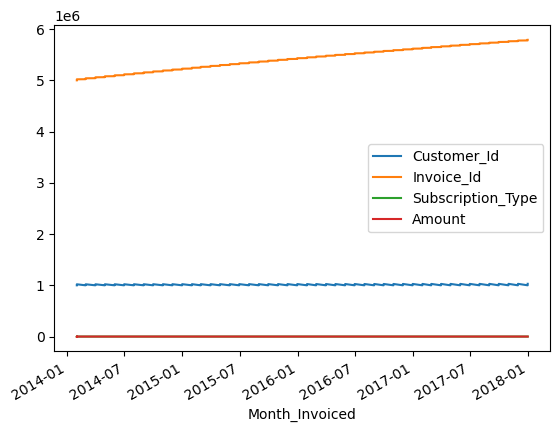

In [10]:
df_plot = df.sort_index()
df_plot.plot()


In [32]:
df_resampled = df
df_resampled = df_resampled.drop(columns = ["Customer_Id", "Invoice_Id"])
train_size = int(.5 * len(df_resampled))
validate_size = int(len(df_resampled) * .3)
test_size = int(len(df_resampled) - train_size - validate_size)
validate_end_index = train_size + validate_size
train = df_resampled[:train_size]
validate = df_resampled[train_size:validate_end_index]
test = df_resampled[validate_end_index:]

In [33]:
df_resampled

,Subscription_Type,Amount
Month_Invoiced,,
2014-01-31,0.0,0.0
2014-01-31,2.0,10.0
2014-01-31,0.0,0.0
2014-01-31,0.0,0.0
2014-01-31,1.0,5.0
...,...,...
2017-12-31,0.0,0.0
2017-12-31,0.0,0.0
2017-12-31,3.0,15.0


In [34]:
def evaluate(target_var):
    '''
    This function will take the actual values of the target_var from validate, 
    and the predicted values stored in yhat_df, 
    and compute the rmse, rounding to 0 decimal places. 
    it will return the rmse. 
    '''
    rmse = round(
        sqrt(
            mean_squared_error(
            validate[target_var],
            yhat_df[target_var])
        ), 0)
    return rmse

    

In [35]:
def plot_and_eval(target_var):
    '''
    This function takes in the target var name (string), and returns a plot
    of the values of train for that variable, validate, and the predicted values from yhat_df. 
    it will als lable the rmse. 
    '''
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label='Train', linewidth=1)
    plt.plot(validate[target_var], label='Validate', linewidth=1)
    plt.plot(yhat_df[target_var], label='Prediction', linewidth=1)
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, f'-- rmse: {round(rmse,2)}')
    plt.legend()
    plt.show()

In [36]:
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])
eval_df

,model_type,target_var,rmse


In [37]:
def append_eval_df(model_type, target_var):
    '''
    this function takes in as arguments the type of model run, and the name of the target variable. 
    It returns the eval_df with the rmse appended to it for that model and target_var. 
    '''
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var], 'rmse': [rmse]}
    return pd.concat([eval_df, pd.DataFrame(d)])

In [38]:
last_sales = train['Subscription_Type'][-1:][0]
last_quantity = train['Amount'][-1:][0]
yhat_df = pd.DataFrame(
    {
    'Subscription_Type': [last_sales],
    'Amount': [last_quantity]
    },
    index = validate.index
)


In [39]:
yhat_df.head()

,Subscription_Type,Amount
Month_Invoiced,,
2015-10-31,0.0,0.0
2015-10-31,0.0,0.0
2015-10-31,0.0,0.0
2015-10-31,0.0,0.0
2015-10-31,0.0,0.0


Subscription_Type -- rmse: 1.0


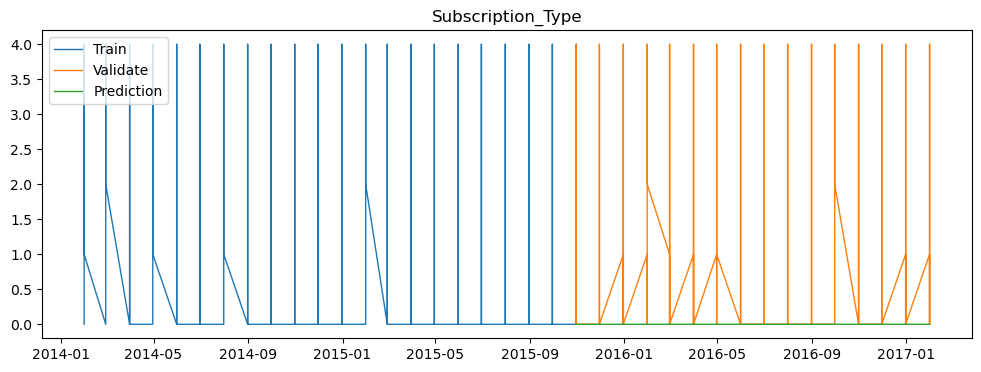

Amount -- rmse: 6.0


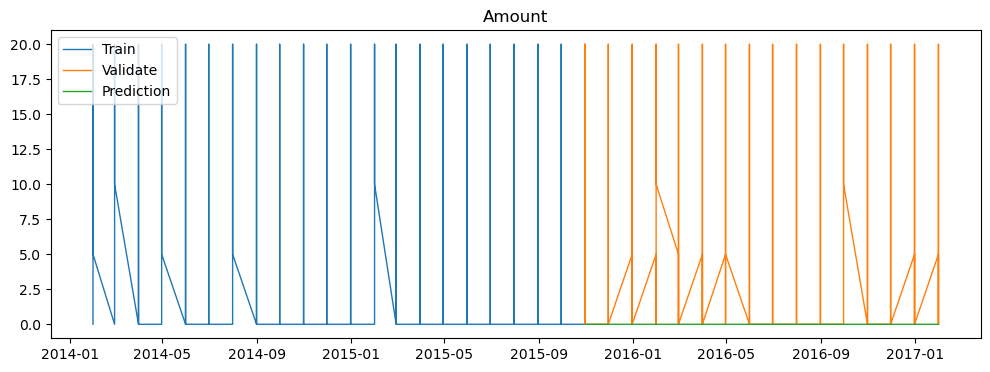

In [40]:
for col in train.columns:
    plot_and_eval(col)

In [41]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'last_observed_value',
                             target_var=col)

In [42]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,Subscription_Type,1.0
0,last_observed_value,Amount,6.0


In [43]:
# compute simple average of sales_total (from train data)
avg_sales = round(train['Subscription_Type'].mean(), 2)

# compute simple average of quantity (from train data)
avg_quantity = round(train['Amount'].mean(), 2)


yhat_df = pd.DataFrame({'Subscription_Type': [avg_sales],
                        'Amount': [avg_quantity]},
                        index=validate.index)

Subscription_Type -- rmse: 1.0


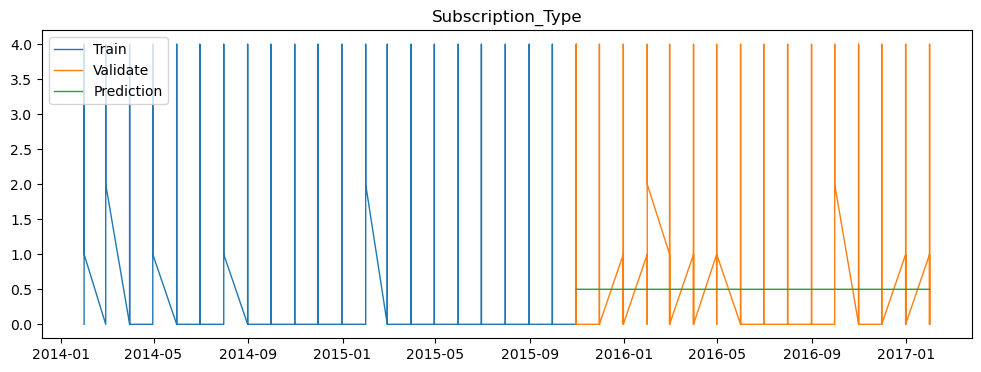

Amount -- rmse: 5.0


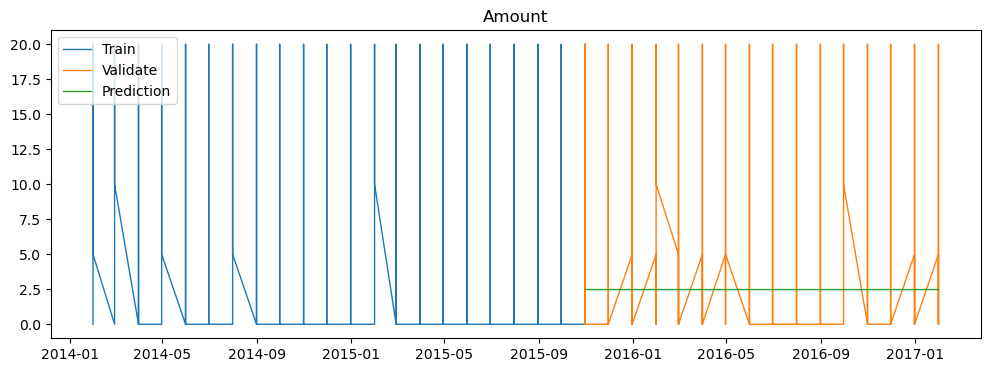

In [44]:
for col in train.columns:
    plot_and_eval(col)

In [45]:
for col in train.columns:
    eval_df = append_eval_df(model_type='simple_average', 
                             target_var = col)
eval_df

,model_type,target_var,rmse
0,last_observed_value,Subscription_Type,1.0
0,last_observed_value,Amount,6.0
0,simple_average,Subscription_Type,1.0
0,simple_average,Amount,5.0


In [46]:
period = 30

rolling_sales = round(
    train['Subscription_Type'].rolling(period).mean()[-1], 2)
rolling_quantity = round(
    train['Amount'].rolling(period).mean()[-1], 2)

# yhat_df = make_predictions()

yhat_df = pd.DataFrame({'Subscription_Type': rolling_sales,
                        'Amount': rolling_quantity},
                         index=validate.index)
yhat_df.head()

,Subscription_Type,Amount
Month_Invoiced,,
2015-10-31,0.57,2.83
2015-10-31,0.57,2.83
2015-10-31,0.57,2.83
2015-10-31,0.57,2.83
2015-10-31,0.57,2.83


Subscription_Type -- rmse: 1.0


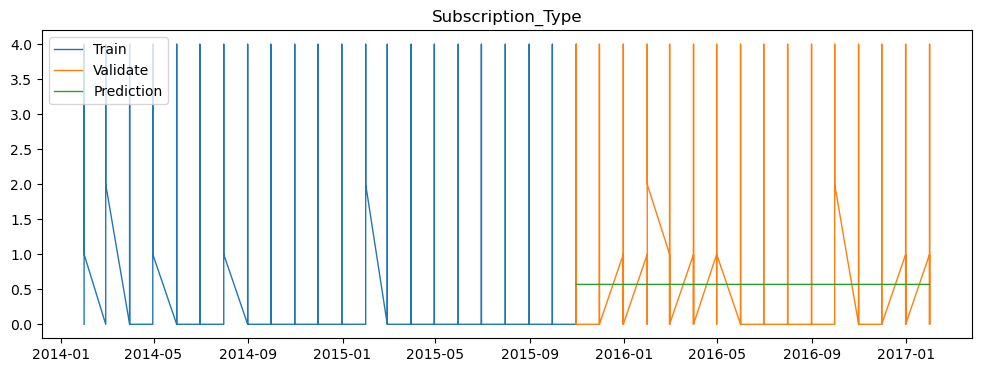

Amount -- rmse: 5.0


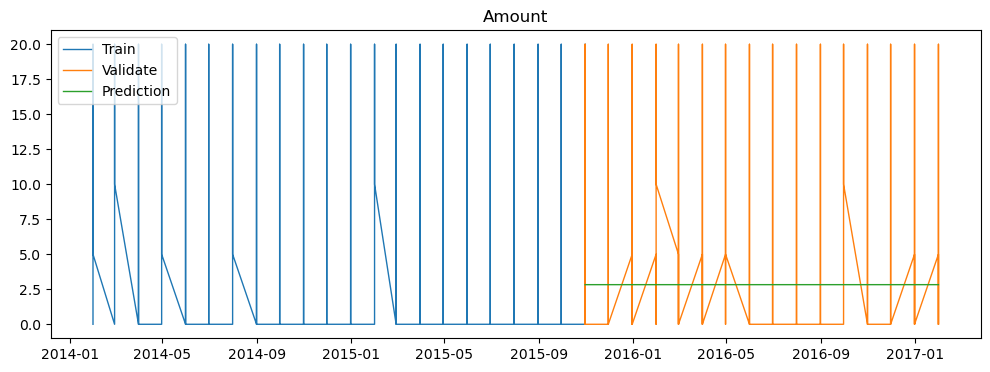

In [47]:
for col in train.columns:
    plot_and_eval(col)

In [48]:
for col in train.columns:
    eval_df = append_eval_df(model_type='30d moving average', 
                             target_var = col)
eval_df

,model_type,target_var,rmse
0,last_observed_value,Subscription_Type,1.0
0,last_observed_value,Amount,6.0
0,simple_average,Subscription_Type,1.0
0,simple_average,Amount,5.0
0,30d moving average,Subscription_Type,1.0
0,30d moving average,Amount,5.0


In [50]:
periods = [4, 12, 26, 52, 104]

for p in periods: 
    rolling_sales = round(
    train['Subscription_Type'].rolling(p).mean()[-1], 2)
    rolling_quantity = round(
    train['Amount'].rolling(p).mean()[-1], 2)
    yhat_df = pd.DataFrame(
        {
            'Subscription_Type' : [rolling_sales],
            'Amount': [rolling_quantity]
        },
        index=validate.index
    )
    model_type = str(p) + '_day_moving_avg'
    # lets update the eval_df (remember we have two targets!)
    for col in train.columns:
        eval_df = append_eval_df(model_type = model_type,
                                 target_var = col)

In [51]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,Subscription_Type,1.0
0,last_observed_value,Amount,6.0
0,simple_average,Subscription_Type,1.0
0,simple_average,Amount,5.0
0,30d moving average,Subscription_Type,1.0
0,30d moving average,Amount,5.0
0,4_day_moving_avg,Subscription_Type,1.0
0,4_day_moving_avg,Amount,5.0
0,12_day_moving_avg,Subscription_Type,1.0
0,12_day_moving_avg,Amount,5.0


In [52]:
eval_df.groupby('target_var')['rmse'].min()

target_var
Amount               5.0
Subscription_Type    1.0
Name: rmse, dtype: float64

In [54]:
min_rmse_sales_total = eval_df.groupby(
    'target_var')['rmse'].min()[1]

min_rmse_quantity = eval_df.groupby(
    'target_var')['rmse'].min()[0]
eval_df[(eval_df.rmse == min_rmse_sales_total) | 
       (eval_df.rmse == min_rmse_quantity)]

,model_type,target_var,rmse
0,last_observed_value,Subscription_Type,1.0
0,simple_average,Subscription_Type,1.0
0,simple_average,Amount,5.0
0,30d moving average,Subscription_Type,1.0
0,30d moving average,Amount,5.0
0,4_day_moving_avg,Subscription_Type,1.0
0,4_day_moving_avg,Amount,5.0
0,12_day_moving_avg,Subscription_Type,1.0
0,12_day_moving_avg,Amount,5.0
0,26_day_moving_avg,Subscription_Type,1.0


In [58]:
combos = list(itertools.product(['add','mul'],[True, False]))

In [63]:
best_score = 'placeholder'
for model in hsts['Subscription_Type']:
    score = sqrt(hsts['Subscription_Type'][model].sse / len(train))
    current_model = {model: score}
    if best_score == 'placeholder':
        best_score = current_model
    else:
        if list(best_score.values())[0] \
        > list(current_model.values())[0]:
            best_score = current_model

In [64]:
best_score

{'hst_fit_0': 0.8999513912163992}

In [ ]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'holts_seasonal', 
                            target_var = col)

In [61]:
eval_df.sort_values(by='rmse')

,model_type,target_var,rmse
0,last_observed_value,Subscription_Type,1.0
0,104_day_moving_avg,Subscription_Type,1.0
0,52_day_moving_avg,Subscription_Type,1.0
0,26_day_moving_avg,Subscription_Type,1.0
0,holts_seasonal,Subscription_Type,1.0
0,4_day_moving_avg,Subscription_Type,1.0
0,12_day_moving_avg,Subscription_Type,1.0
0,30d moving average,Subscription_Type,1.0
0,simple_average,Subscription_Type,1.0
0,4_day_moving_avg,Amount,5.0
